# Lab 04: Extracting topics from research articles

# Part I: Data preprocessing

### Load dataset

- Source: https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles/version/1
- Download: https://georgetown.box.com/s/1qkrvdewe8ez35f2asblxysh136dvh6b

In [1]:
import pandas as pd
 
train_data = pd.read_csv('research-articles-dataset/train.csv').sample(frac=1)
test_data = pd.read_csv('research-articles-dataset/test.csv').sample(frac=1)

In [2]:
train_data

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
2981,2982,Functional renormalization-group approach to t...,A possibility of the topological Kosterlitz-...,0,1,0,0,0,0
10743,10744,Transfer Learning for Brain-Computer Interface...,Almost all EEG-based brain-computer interfac...,0,0,0,1,1,0
9580,9581,Effects of transmutation elements in tungsten ...,Tungsten (W) is widely considered as the mos...,0,1,0,0,0,0
3384,3385,Exploring Neural Transducers for End-to-End Sp...,"In this work, we perform an empirical compar...",1,0,0,0,0,0
4542,4543,Emergent transport in a many-body open system ...,We analyze an open many-body system that is ...,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8219,8220,Transversality for local Morse homology with s...,We prove the transversality result necessary...,0,0,1,0,0,0
5920,5921,Reconstruction of Hidden Representation for Ro...,This paper aims to develop a new and robust ...,1,0,0,1,0,0
1164,1165,System Description: Russell - A Logical Framew...,Russell is a logical framework for the speci...,1,0,1,0,0,0
14754,14755,Voevodsky's conjecture for cubic fourfolds and...,In the first part of this paper we will prov...,0,0,1,0,0,0


In [3]:
for topic in train_data.columns[3:]:
    print(f"{topic}: {sum(train_data[topic]) / len(train_data):.3f}")

Computer Science: 0.410
Physics: 0.287
Mathematics: 0.268
Statistics: 0.248
Quantitative Biology: 0.028
Quantitative Finance: 0.012


### Reuse Spacy pipeline from Lab-02 for text normalization & preprocessing

In [4]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [5]:
conda install -c conda-forge spacy-model-en_core_web_sm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/jieyisun/opt/miniconda3/envs/TF

  added / updated specs:
    - spacy-model-en_core_web_sm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.24  |       h4653dfc_0         150 KB  conda-forge
    certifi-2022.9.24          |     pyhd8ed1ab_0         155 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         305 KB

The following packages will be UPDATED:

  ca-certificates                      2022.9.14-h4653dfc_0 --> 2022.9.24-h4653dfc_0
  certifi                            2022.9.14-pyhd8ed1ab_0 --> 2022.9.24-pyhd8ed1ab_0




In [6]:
import re
import spacy
from spacy.language import Language

M = 2500

pipeline = spacy.load('en_core_web_sm')

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "number"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Stips extra whitespace
]

train_sentences = []
for i, d in enumerate(train_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)


@Language.component("lab04Preprocessor")
def ng20_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return " ".join(tokens)


pipeline.add_pipe("lab04Preprocessor")

/Users/jieyisun/opt/miniconda3/envs/TF/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<function __main__.ng20_preprocess(doc)>

### Pass data through our Spacy pipeline

In [7]:
docs = []
for sent in train_sentences[:M]:
    docs.append(pipeline(sent))

### Compute number of unique words (vocabulary size)

In [8]:
vocab_size = len(set(" ".join(docs).split(" ")))
vocab_size

16961

# Part 2: Build Features

### Build the term-document matrix (i.e., BOW features)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse._csr.csr_matrix, (2500, 1996))

### Create a index-to-word map

In [10]:
idx2word = {idx: word for word, idx in bow_featurizer.vocabulary_.items()}

### Number of topics hyperparameter

In [11]:
# Configurable
K = 10

### Plotting subroutine to visualize words

In [12]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(model, feature_names, n_top_words, title):
    plt.clf()
    cols = 5
    rows = K // 5 + K % 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### (10 pts) Task I: Build a LSA model

In this task we are going to build a LSA topic model from scratch. From lecture-04, we learned about LSA from the perspective of document retrieval. For document retrieval, you'll recall that we computed a truncated SVD by choosing some number of dimension $K << N$. This gave us the left singular column vectors, $\mathbf{V} \in \mathbb{R}^{N \times K}$, and the diagonal singular value matrix, $\boldsymbol{\Sigma} \in \mathbb{R}^{K \times K}$ that we needed in order to project our queries, $\mathbf{q} \in \mathbb{R}^{N}$, and documents, $\mathbf{d} \in \mathbb{R}^{N}$, into $\mathbb{R}^{K}$ space. Recall that the operation to do that was:

$$\hat{\mathbf{q}} = \mathbf{q}\mathbf{V}\mathbf{\Sigma}^{-1} $$

In this task, we're going to evaluate the singular values, $\sigma_{i,j}$ in $\mathbf{\Sigma}$, and their corresponding basis vectors, $\mathbf{u}^{(j)}$, in $\mathbf{U}$, to extract the principal themes in the data. Execute the following subtasks.

1. For each column vector, print out the top 10 most relevant words.
2. Visualize the top 10 words using the `plot_topics()` function provided above.
3. What affect does the hyperparameter $K$ have on the result?
4. Is there a principled way to determine an appropriate value for $K$?

In [13]:
from sklearn.decomposition import TruncatedSVD

Top 10 most relevant words for each column vector: 
Columan Vetor1: number, model, result, method, datum, time, base, problem, high, study
Columan Vetor2: number, rm, _number, mathbb, mass, galaxy, stellar, star, planet, pm
Columan Vetor3: model, parameter, mass, galaxy, effect, speech, bayesian, latent, rm, generative
Columan Vetor4: network, neural, datum, deep, learn, task, image, method, learning, feature
Columan Vetor5: network, field, state, energy, phase, high, study, structure, result, quantum
Columan Vetor6: network, problem, algorithm, graph, model, time, neural, solution, mathcal, optimal
Columan Vetor7: method, function, network, propose, convex, model, non, distribution, class, gradient
Columan Vetor8: datum, result, group, algebra, set, mathbb, function, graph, prove, class
Columan Vetor9: method, time, datum, problem, network, graph, estimate, cluster, control, large
Columan Vetor10: state, graph, method, time, group, algebra, problem, task, mathcal, structure


<Figure size 640x480 with 0 Axes>

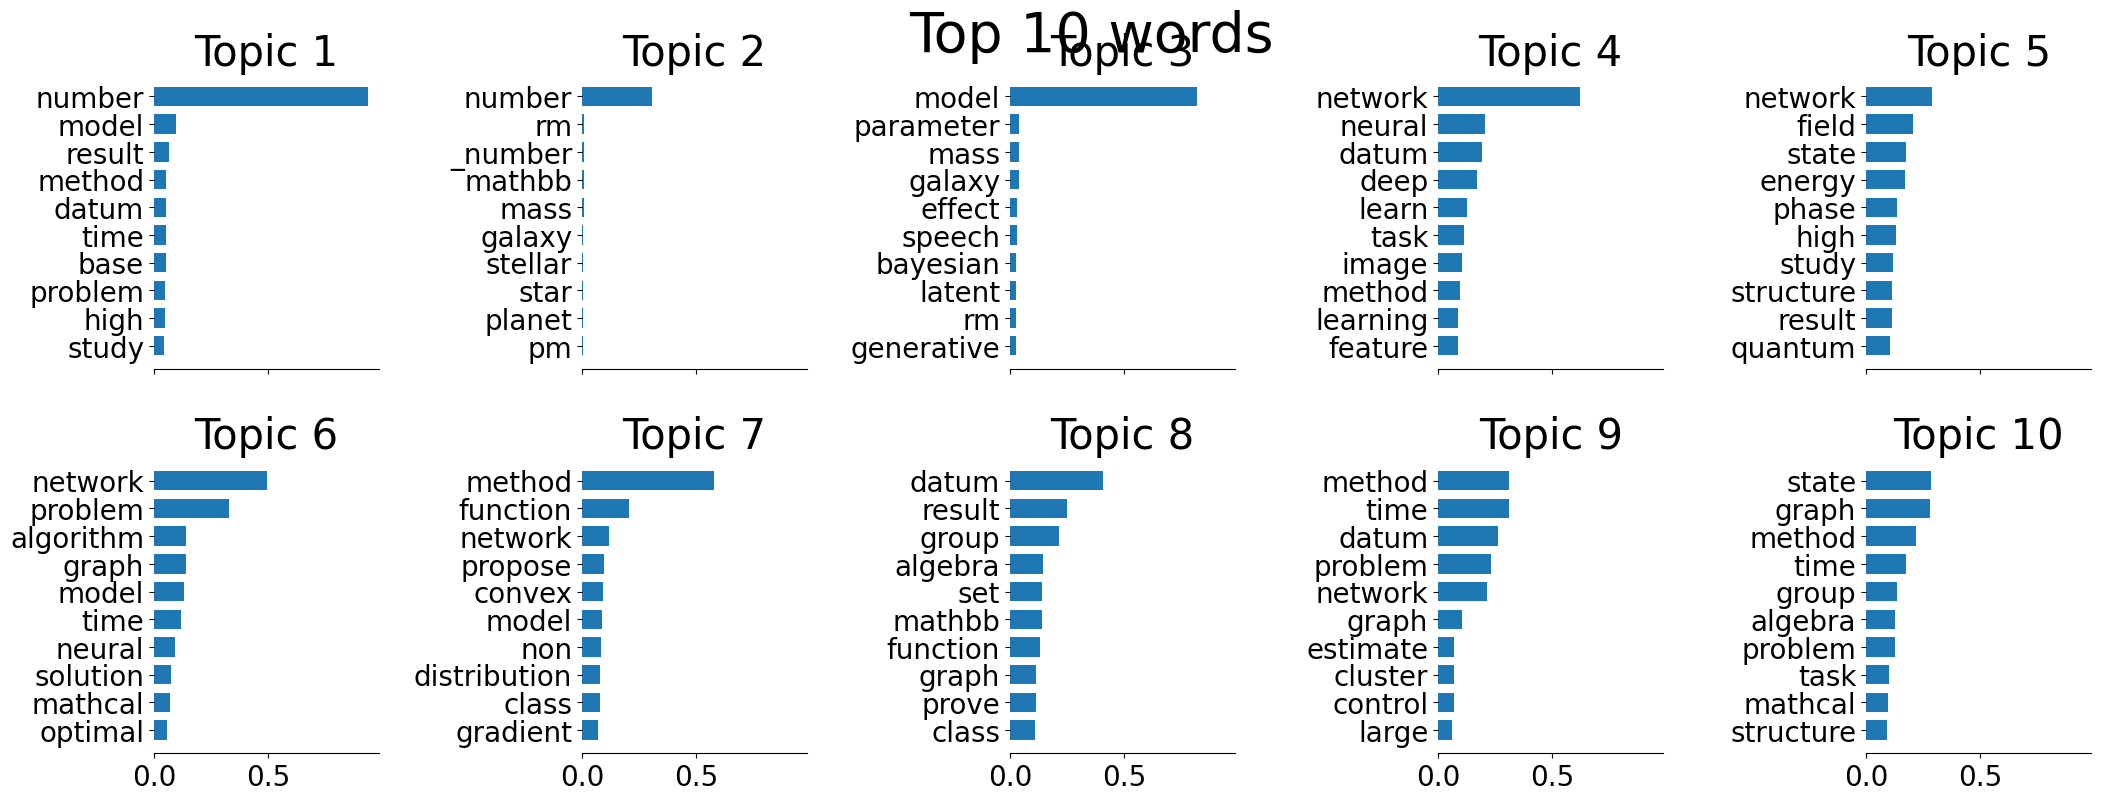

In [14]:
lsa = TruncatedSVD(K)
temp = lsa.fit_transform(X_bow)
n_pick_keywords = 10
topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(K)]
print("Top 10 most relevant words for each column vector: ")
for i, ids in enumerate(topic_keywords_id):
    temp = []
    for id in ids:
        temp.append(idx2word[id])
    keywords = ", ".join(temp)
    print("Columan Vetor" + str(i + 1) + ": " + keywords)
plot_top_words(lsa, idx2word, 10, "Top 10 words")

K is the number of topics we assume, generally less than the number of texts

I think the choice of K will have a huge impact on the results, and K cannot be calculated. It us an empirical value, so it is difficult to find a principled way to get a reasonable K value. The only thing we can do is try different K value, and choose the best one.

### (5 pts) Task 2: Perform topic extraction using the NMF and LDA models from sklearn

In this task we perform topic extraction using the Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) models provided by sklearn. 

1. Fit the NMF and LDA models in the provided cells below.
2. Visualize the results using the `plot_topics` function.
3. How do the results compare to your home-spun LSA topic model?
4. What are the differences between these model that might give rise to these results?

In [15]:
from sklearn.decomposition import NMF

/Users/jieyisun/opt/miniconda3/envs/TF/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


<Figure size 640x480 with 0 Axes>

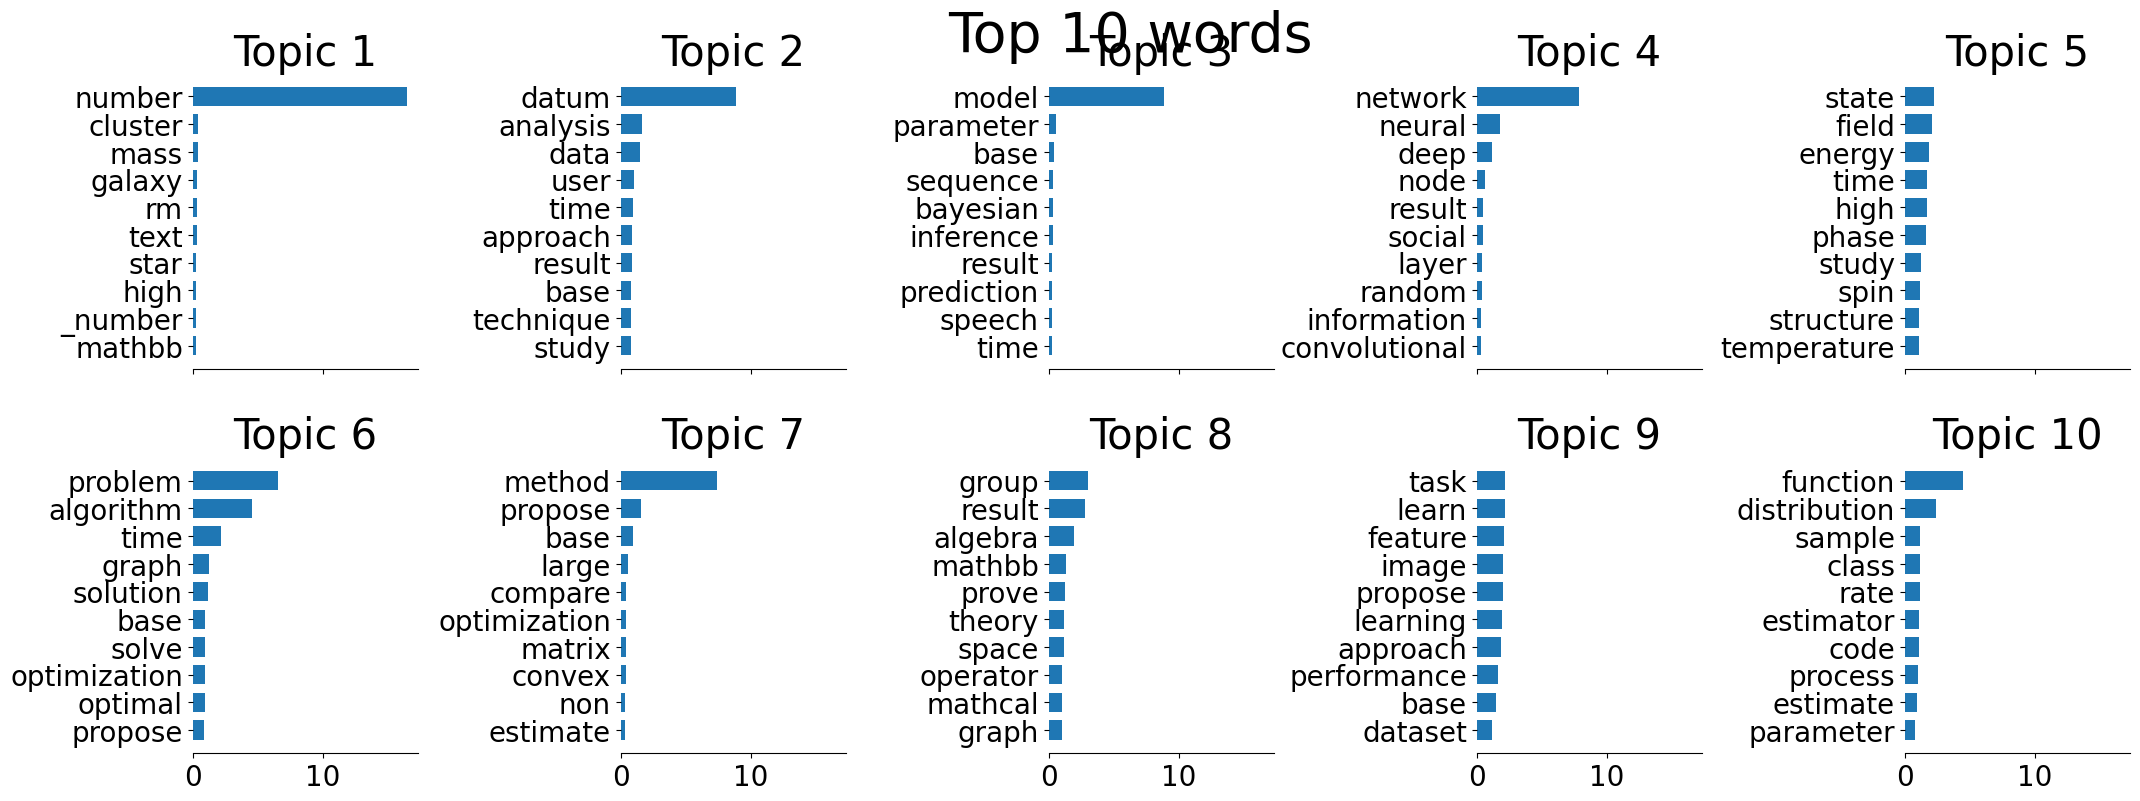

In [16]:
nmf = NMF(n_components=K)
temp = nmf.fit(X_bow)
plot_top_words(nmf, idx2word, 10, "Top 10 words")

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
topword_dict={'Topic{}'.format(i+1):None for i in range(K)}
for i in range(len(lda.components_)):
    curr_topic='Topic{}'.format(i+1)
    print(curr_topic)
    topword_dict[curr_topic]=[idx2word[k] for k in lda.components_[i].argsort()[::-1][:10]]
    print(topword_dict[curr_topic])

Topic1
['network', 'datum', 'base', 'paper', 'user', 'time', 'analysis', 'information', 'provide', 'model']
Topic2
['number', 'result', 'pattern', 'sequence', 'rate', 'manifold', 'channel', 'category', 'cell', 'growth']
Topic3
['number', 'group', 'mathcal', 'code', 'structure', 'beam', 'high', '_number', 'energy', 'element']
Topic4
['equation', 'solution', 'problem', 'time', 'model', 'flow', 'control', 'numerical', 'method', 'energy']
Topic5
['number', 'model', 'high', 'galaxy', 'mass', 'cluster', 'low', 'star', 'alpha', 'present']
Topic6
['model', 'method', 'algorithm', 'distribution', 'propose', 'estimate', 'sample', 'estimation', 'datum', 'base']
Topic7
['model', 'network', 'datum', 'method', 'learn', 'propose', 'neural', 'feature', 'approach', 'learning']
Topic8
['number', 'problem', 'algorithm', 'graph', 'function', 'result', 'set', 'optimization', 'gradient', 'convex']
Topic9
['number', 'theory', 'mathbb', 'space', 'group', 'order', 'prove', 'result', 'field', 'quantum']
Topic10


<Figure size 640x480 with 0 Axes>

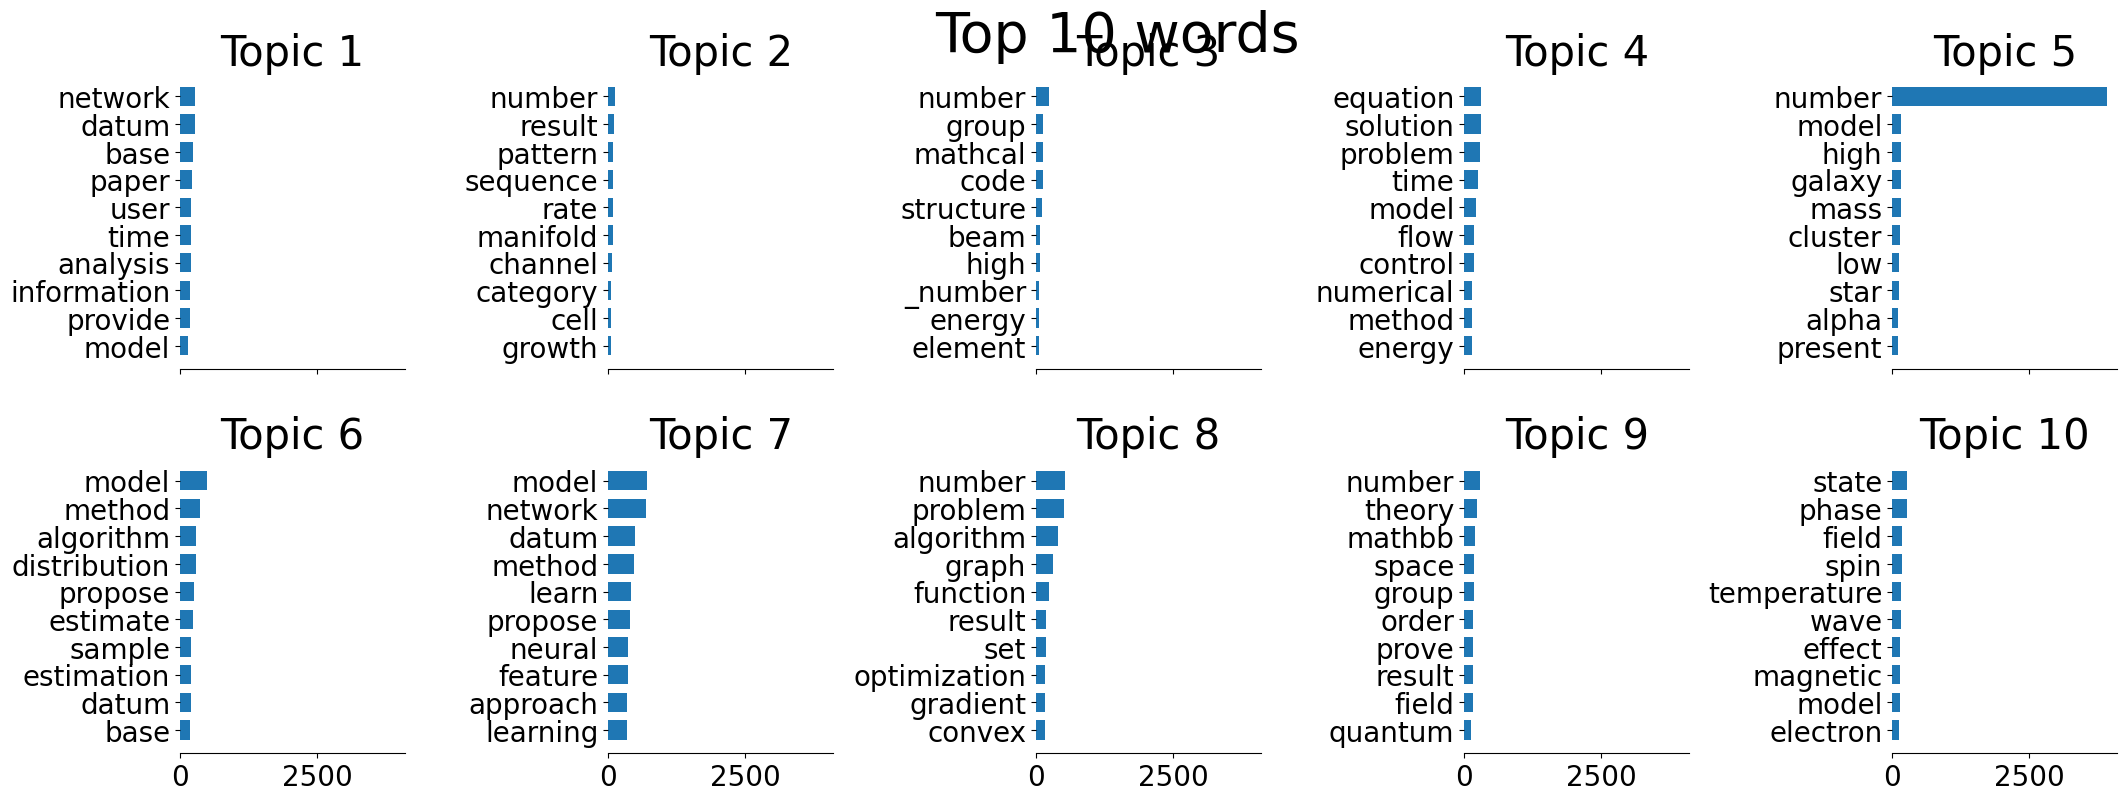

In [18]:
lda = LatentDirichletAllocation(n_components=K)
temp = lda.fit(X_bow)
plot_top_words(lda, idx2word, 10, "Top 10 words")

#### 3. How do the results compare to your home-spun LSA topic model?
The result of NMF gives each words more weights. In some topics, the top1 words are distinguishable from the other words.
The result of LDA gives each words less weights. Only topic 5 has a lead word 'number'. Some topics even don't have a lead word.

#### 4. What are the differences between these model that might give rise to these results?
NMF: The weights in the topic word should be positive. But the result could be less accurate due to its constraints to force fit a non-negative solution.
SVD: The weights in the topic word matrix are allowed to be negative and there is no constraints on the results. But this may lead to a less interpretable result.
LDA: LDA assumes that the prior distribution of both (docu, topic) and (word, docu) are Dirichlet and apply Bayes.


### (5 pts) Task 3: Map the test data onto the topic spaces learned from the LSA, NMF, and LDA models

The purpose of this task is to assign topics to the test data

In [20]:
# Your code goes here
test_sentences = []
for i, d in enumerate(test_data['ABSTRACT'][:M]):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    test_sentences.append(d)

docs_test = []
for sent in test_sentences[:M]:
    docs_test.append(pipeline(sent))
    
vocab_size_test = len(set(" ".join(docs_test).split(" ")))

bow_featurizer_test = CountVectorizer(max_features=vocab_size_test, max_df=0.95, min_df=0.005, stop_words='english')
#tfidf_featurizer_test = TfidfVectorizer(max_features=vocab_size_test, max_df=0.95, stop_words='english')
X_bow_test = bow_featurizer_test.fit_transform(docs_test)
#X_tfidf_test = tfidf_featurizer.fit_transform(docs_test)

idx2word_test = {idx: word for word, idx in bow_featurizer_test.vocabulary_.items()}

In [22]:
import numpy as np
svd = TruncatedSVD(K)
class1 = svd.fit_transform(X_bow_test)
class1

array([[ 1.976917  ,  0.2979802 , -0.07339591, ..., -0.09325323,
         0.02711603, -0.17370932],
       [ 6.46994945, -3.91705927, -1.17529055, ..., -0.5953454 ,
         0.37019032, -2.23323751],
       [ 0.30343485, -0.9841163 , -0.56962997, ..., -0.46984633,
        -0.16484675,  0.02207853],
       ...,
       [ 1.79803894, -1.82569568, -1.60236411, ..., -1.67890191,
         5.32788663,  4.20593986],
       [ 6.02239407, -2.5129907 ,  0.57809173, ..., -2.51680769,
         0.2492473 ,  0.14362947],
       [ 1.18363329, -2.32596648, -0.48547825, ...,  0.42747655,
         1.48375312,  1.0692668 ]])

In [23]:
np.argmax(class1, axis=1)

array([0, 0, 0, ..., 8, 0, 8])

In [24]:
class3 = lda.fit_transform(X_bow_test)
np.argmax(class3, axis=1)

array([4, 9, 8, ..., 4, 7, 1])